## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.** 

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo). 



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder). 

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

In [9]:
import numpy as np
import tensorflow as tf
import keras
import optuna

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# “First, we will need a custom layer to sample the codings, given μ and γ”

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


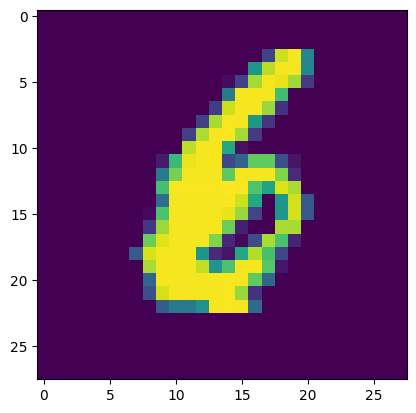

In [5]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.imshow(x_train[129])

In [10]:
# To perform hyperparameter optimization, we define the VAE model with Optuna as the following def

def HO(trial):
    
    # perform hyperparameter optimization
    codings_size = trial.suggest_int('codings_size', 5, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 64, 256)

    # “Create the encoder, using the functional API ”
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28))
    Z = tf.keras.layers.Flatten()(encoder_inputs)
    Z = tf.keras.layers.Dense(150, activation="relu")(Z)
    Z = tf.keras.layers.Dense(100, activation="relu")(Z)
    codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(
        inputs=[encoder_inputs], outputs=[codings_mean, codings_log_var, codings])
    #variational_encoder.summary()
    
    # Build decoder
    decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
    x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
    x = tf.keras.layers.Dense(150, activation="relu")(x)
    x = tf.keras.layers.Dense(28 * 28)(x)
    outputs = tf.keras.layers.Reshape([28, 28])(x)
    variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    #variational_decoder.summary()

    # "Build the variational autoencoder model"
    _, _, codings = variational_encoder(encoder_inputs)
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

    # "Add the latent loss and the reconstruction loss"
    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)
    variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

    # “Compile and fit the autoencoder"
    variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam(learning_rate))
    history = variational_ae.fit(x_train, x_train, epochs=25, batch_size=batch_size,
                                 validation_data=(x_test, x_test), verbose=0)

    # Return the validation loss as the objective value
    return history.history['val_loss'][-1]

In [12]:
# Perform hyperparameter optimization using Optuna

study = optuna.create_study(direction='minimize')
study.optimize(HO, n_trials=25)

[I 2023-12-18 03:07:00,961] A new study created in memory with name: no-name-29120e36-e3ce-4cb4-b942-f8a635b668eb
[I 2023-12-18 03:08:38,587] Trial 0 finished with value: 0.03918235003948212 and parameters: {'codings_size': 8, 'learning_rate': 0.0006854155681414421, 'batch_size': 241}. Best is trial 0 with value: 0.03918235003948212.
[I 2023-12-18 03:10:36,254] Trial 1 finished with value: 0.04164019972085953 and parameters: {'codings_size': 8, 'learning_rate': 0.008030330841935746, 'batch_size': 197}. Best is trial 0 with value: 0.03918235003948212.
[I 2023-12-18 03:12:40,153] Trial 2 finished with value: 0.043030526489019394 and parameters: {'codings_size': 11, 'learning_rate': 0.009905937821632488, 'batch_size': 165}. Best is trial 0 with value: 0.03918235003948212.
[I 2023-12-18 03:16:01,592] Trial 3 finished with value: 0.047791361808776855 and parameters: {'codings_size': 19, 'learning_rate': 0.009986696312107439, 'batch_size': 74}. Best is trial 0 with value: 0.03918235003948212

In [13]:
# the best hyperparameters

best_params = study.best_params
best_codings_size = best_params['codings_size']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
print(best_codings_size, best_learning_rate, best_batch_size)

11 0.0022998064415628247 137


In [15]:
# Build the final VAE model one more time base on the best hyperparameters we find

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(best_codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(best_codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = tf.keras.layers.Input(shape=[best_codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam(best_learning_rate))
history = variational_ae.fit(x_train, x_train, epochs=25, batch_size=best_batch_size,
                             validation_data=(x_test, x_test))

Epoch 1/25
438/438 [==============================] - 14s 21ms/step - loss: 0.0531 - val_loss: 0.0448
Epoch 2/25
438/438 [==============================] - 5s 12ms/step - loss: 0.0437 - val_loss: 0.0425
Epoch 3/25
438/438 [==============================] - 4s 10ms/step - loss: 0.0422 - val_loss: 0.0415
Epoch 4/25
438/438 [==============================] - 6s 13ms/step - loss: 0.0413 - val_loss: 0.0409
Epoch 5/25
438/438 [==============================] - 5s 12ms/step - loss: 0.0409 - val_loss: 0.0406
Epoch 6/25
438/438 [==============================] - 5s 11ms/step - loss: 0.0404 - val_loss: 0.0402
Epoch 7/25
438/438 [==============================] - 5s 11ms/step - loss: 0.0402 - val_loss: 0.0398
Epoch 8/25
438/438 [==============================] - 7s 15ms/step - loss: 0.0399 - val_loss: 0.0396
Epoch 9/25
438/438 [==============================] - 6s 15ms/step - loss: 0.0398 - val_loss: 0.0396
Epoch 10/25
438/438 [==============================] - 6s 14ms/step - loss: 0.0396 - val_l

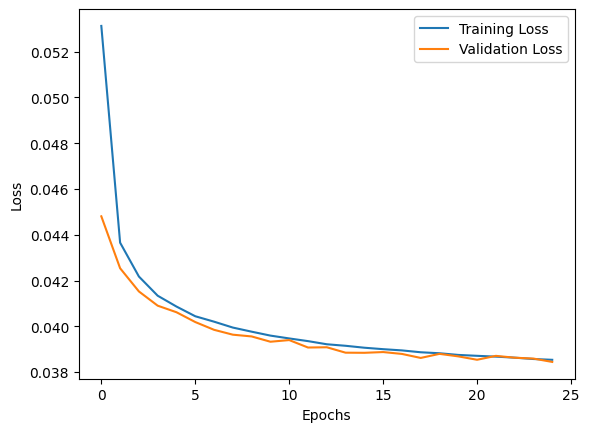

In [16]:
# Plot the loss curves for the training and validation sets

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1875/1875 [==============================] - 15s 7ms/step


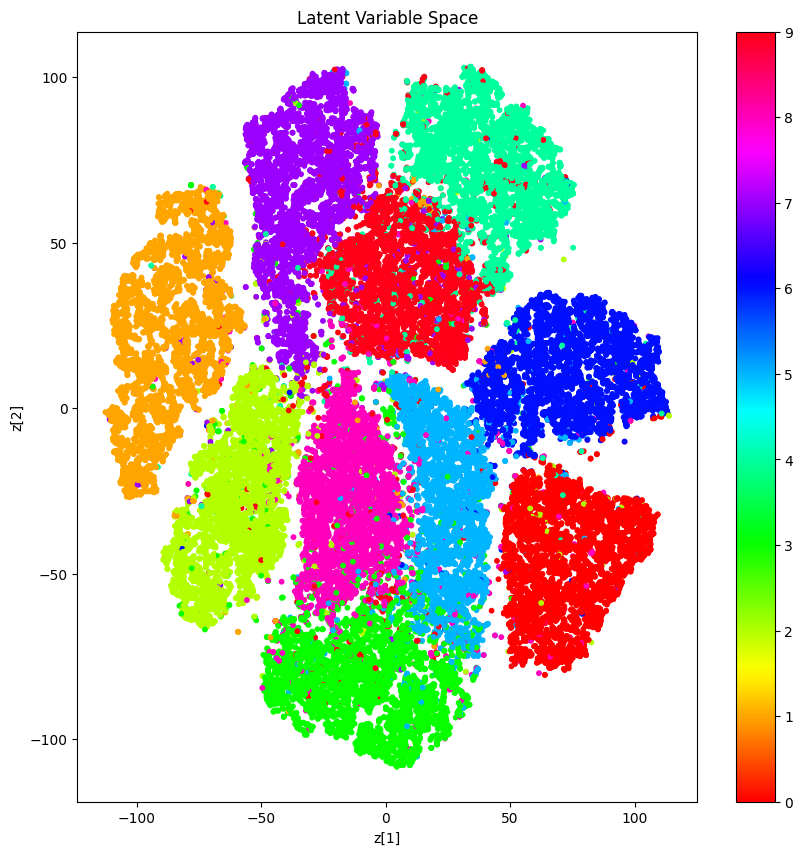

In [78]:
# Replicate the figure showing the final latent variable space, the final latent space (z_1, z_2).

from sklearn.manifold import TSNE

z_mean, _, _ = variational_encoder.predict(x_train)
z_mean_tsne = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(10, 10))
plt.scatter(z_mean_tsne[:, 0], z_mean_tsne[:, 1], c=y_train, cmap='hsv', s=10)
plt.colorbar()
plt.xlabel("z[1]")
plt.ylabel("z[2]")
plt.title('Latent Variable Space')
plt.show()

313/313 [==============================] - 1s 4ms/step


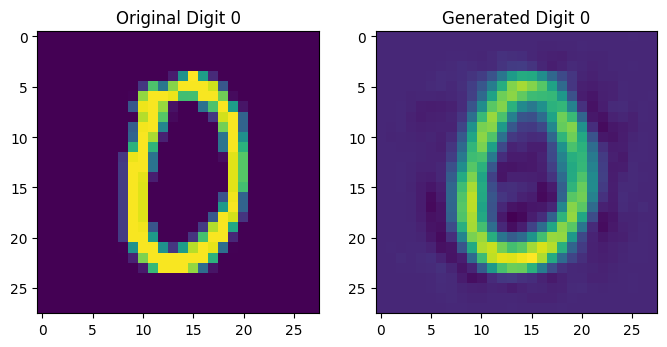

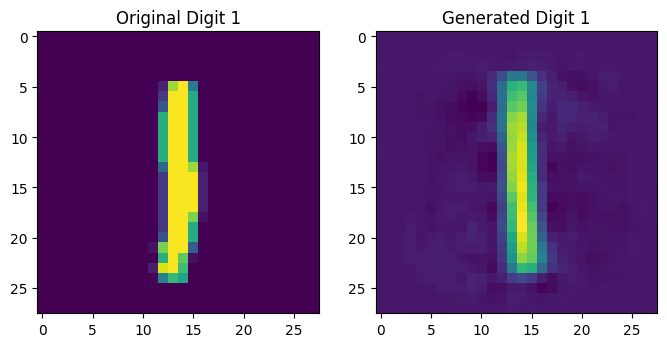

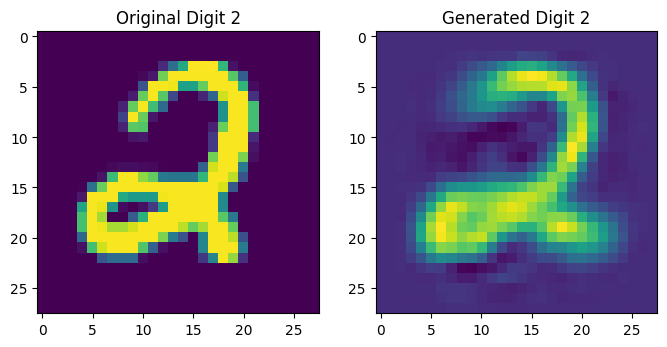

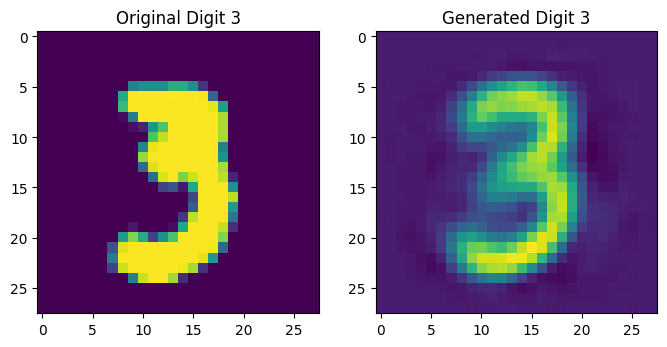

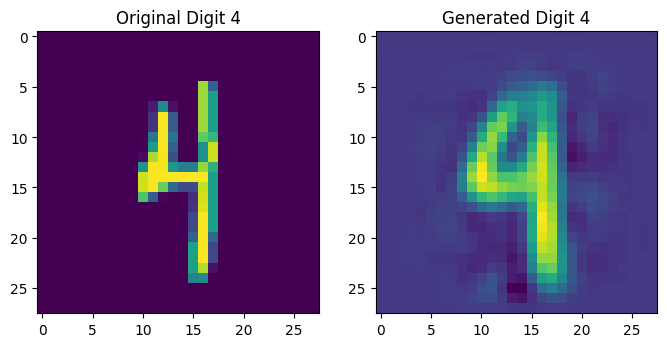

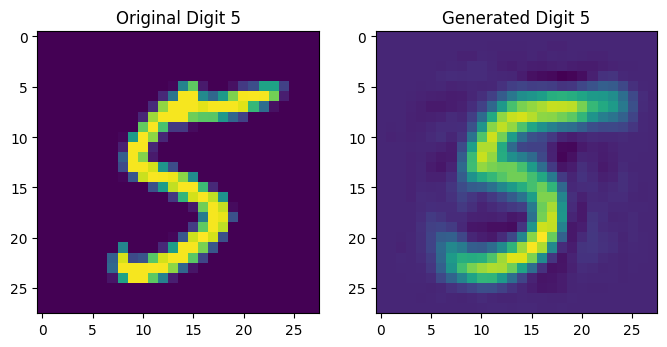

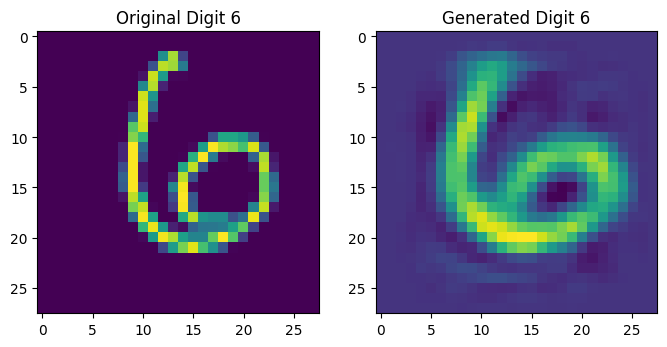

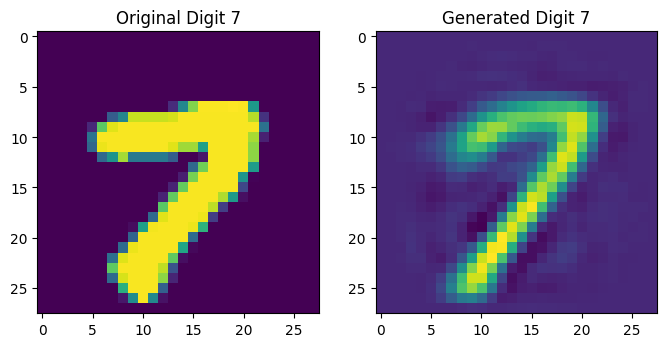

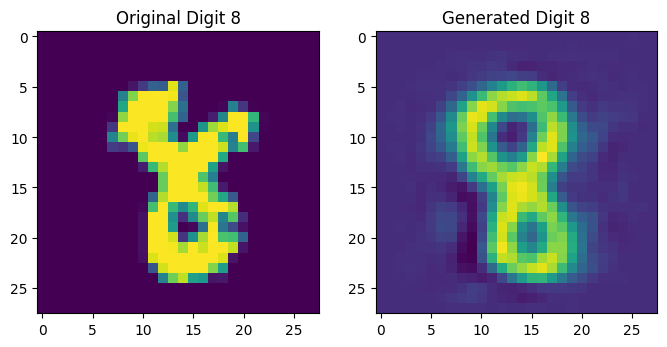

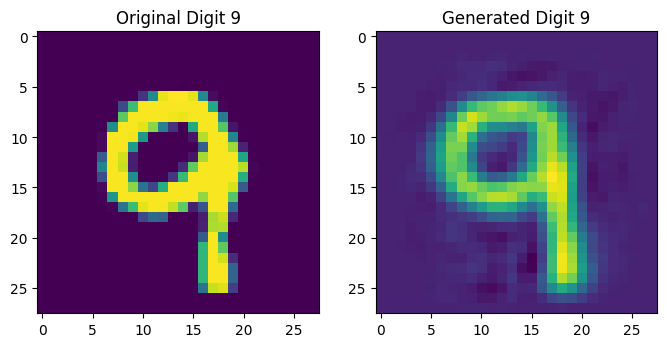

In [104]:
# Plot VAE generated images for all digits 0-9 after model training

decoded_digits = variational_ae.predict(x_test)

for digit in range(10):
    # Pick a image of the target digit
    idx = np.where(y_test == digit)[0][10]

    # Original image
    original_image = x_test[idx].reshape(28, 28)
    # VAE generated image
    generated_image = decoded_digits[idx].reshape(28, 28)

    # Plotting side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Digit {digit}')

    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.title(f'Generated Digit {digit}')
    plt.show()

You have two implementation options: (1) All in one notebook (2) Github repo. 

### Option 1: All in one Colab notebook

You submit a single Colab notebook URL that contains all the code and the outputs. Your notebook should be self-contained and can be launched in Google Colab using a corresponding button at the top of the notebook. See the regression notebook in the course site for an example of such button. You **need to save all outputs in the notebook** so that the TAs can check that your code is working properly. 

### Option 2: Github repo 

If you prefer to work without notebooks, with containers or not, you can submit the implementation python scripts and version control your code in a private Github repo. You have to submit the Github URL and clearly document the way to launch the runtime / install requirements.txt and include all required figures in the README.md file. 

IMPORTANT: Ensure that the github repo remains private. If you submit a public github repo you will be held responsible for violating the honor code.